# Model Training and Tuning

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score, confusion_matrix,  plot_roc_curve, roc_curve, auc

In [2]:
# Change this variable to 0 if you use jupyter notebook, or 1 if you use google colab
use_colab = 0

import os
if use_colab:
    from google.colab import files
    import io

if os.path.exists('dataset'):
    print('Dataset folder exists')
else:
    print('Dataset folder not exists. A dataset folder will be created.')
    os.mkdir('dataset')

def file_exists(parent_directory, file_name):
    path = os.path.join(parent_directory, file_name)
    if os.path.exists(path):
        return 1
    else:
        return 0
    
def read_csv_file(use_colab, file_name):
    if file_exists('dataset', file_name):
        return pd.read_csv('dataset/'+file_name)
    else:
        print("Please upload the file or create one by running previous section's csv export.")
        if use_colab:
            print("Please upload file: {}".format(file_name))
            upload_file = files.upload()
            return pd.read_csv(io.BytesIO(upload_file[file_name]))

Dataset folder exists


## Import Data

In [3]:
train = read_csv_file(use_colab, 'train_weather_FE.csv')
test = read_csv_file(use_colab, 'test_weather_FE.csv')

In [4]:
train.drop(columns=['Date'], inplace=True)
test.drop(columns=['Date'], inplace=True)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8475 entries, 0 to 8474
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Latitude          8475 non-null   float64
 1   Longitude         8475 non-null   float64
 2   WnvPresent        8475 non-null   int64  
 3   week_of_year      8475 non-null   int64  
 4   dist_to_stat_1    8475 non-null   float64
 5   dist_to_stat_2    8475 non-null   float64
 6   infection_rate    8475 non-null   float64
 7   ('high_rate',)    8475 non-null   float64
 8   ('north_high',)   8475 non-null   float64
 9   ('north_low',)    8475 non-null   float64
 10  ('south_high',)   8475 non-null   float64
 11  ('south_low',)    8475 non-null   float64
 12  Heat              8475 non-null   float64
 13  Cool              8475 non-null   float64
 14  Depart            8475 non-null   int64  
 15  DarkHours         8475 non-null   float64
 16  Tavg_Rol7         8475 non-null   float64


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Id                116293 non-null  int64  
 1   Latitude          116293 non-null  float64
 2   Longitude         116293 non-null  float64
 3   week_of_year      116293 non-null  int64  
 4   dist_to_stat_1    116293 non-null  float64
 5   dist_to_stat_2    116293 non-null  float64
 6   infection_rate    116293 non-null  float64
 7   ('high_rate',)    116293 non-null  float64
 8   ('north_high',)   116293 non-null  float64
 9   ('north_low',)    116293 non-null  float64
 10  ('south_high',)   116293 non-null  float64
 11  ('south_low',)    116293 non-null  float64
 12  Heat              116293 non-null  float64
 13  Cool              116293 non-null  float64
 14  Depart            116293 non-null  int64  
 15  DarkHours         116293 non-null  float64
 16  Tavg_Rol7         11

## Baseline Model

On our case, predicting false negative means missing up on the actual West Nile Virus presence, preventing us to perform any prevention action to avoid people from falling sick. On the other hand, having false positive means we over-spray pesticide. From here we can see that we need to put a higher emphasize on predicting false negative as the cost is significantly higher than having false positive (detailed explanation in Model Discussion notebook). 

Therefore, the baseline model for this case will be a model that is extra sensitive, i.e. predict all traps on all time to have WNV to prevent a single false negative appearance. 

In [7]:
train['WnvPresent'].value_counts(normalize=True)

0    0.946077
1    0.053923
Name: WnvPresent, dtype: float64

Based on the score above, the baseline model will accurately predict the dataset with precision of 5.4%. 

## Data Preparation
### Declaring Features & Target Variable

In [8]:
X = train.drop(columns=['WnvPresent'])
y = train['WnvPresent']

print(X.shape, y.shape)

(8475, 20) (8475,)


### Train/Test Split 

We will first split the train data into train and validation dataset. These subsets of data will help in unbiased evaluation of our models and prevent overfitting.

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y,
                                                  stratify=y, 
                                                  random_state=42)

# checking the shape of both train and val dataset
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(6356, 20) (2119, 20) (6356,) (2119,)


### Preprocessing

We will perform the following preprocessing steps:
- Scaling : StandardScaler is used for scaling the data as we will be using Logistic Regression with regularization which requires scaling. 
- Imbalance Class Treatment : As the target classes are imbalanced, we will synthesize artificial data on the minority class to provide a better minority class representation in our training dataset.

#### Standard Scaling

In [10]:
# Scale the features
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)

#### Imbalance Data Treatment

As our data is highly imbalance (only 5% of WNV presence), we will need to treat the data to improve the model performance. We did try to use stratify on train_test_split to ensure we provide sufficient data on each class for both train and test set. According to our experiment, doing this cause some models to perform very badly. Therefore, we need to produce more data and the approach we find produce to find the best model is by using **Synthetic Minority Oversampling Technique (SMOTE)**. 

In [11]:
# Create more datapoints through the use of SMOTE
sm = SMOTE(random_state=42)

X_train_sm, y_train_sm = sm.fit_resample(X_train_sc, y_train)

In [12]:
# Checking the number of rows & columsn again in train after smoting
print(X_train_sm.shape, y_train_sm.shape)

(12026, 20) (12026,)


After smoting we now have 12026 rows in instead of the initial 8475 rows.

## Modelling

### Model Selection

Here we will run different models and will tune the hyperparameters to further improve the model. In determining the metrics to evaluate the model, we first look at the types of prediction error we could get - **Type 1 error and Type 2 error**.

**False Positive Rate(FPR)** is the fraction of false alerts based on model predictions which is when model predicting WNV present when it actually is not. From goverment's perspective, should there be infact not a WNV present and spraying efforts were made, it would be inefficient use of resources. And if people were made alarmed that their living area indicated presence of WNV, they may purchase mosquito repellents when they don't actually need to.

**False Negative Rate(FNR)** is the fraction of missed detection based on model predictions which is when model predicting that WNV is not present when it actually is.This might result in the residents not finding the need to buy mosquito repellents or any precautions which might result in an outbreak resulting in high healthcare costs due to this.

From the above two types of error, Type 2 is more disastrous than Type 1 error from cost basis as well as from the value of human life. Therefore our model should reduce the **False positives** as much as possible.

### Scoring Metrics

The precision-recall trade-off shows how to strike a balance between false positive and false negative rates. Precision measures how accurate the model is at estimating positive labels (in this case, the existence of WNV) and is a reasonable criterion to use when the cost of a false positive is greater than the cost of a false negative.

Recall calculates the percentage of actual positives a model correctly identified (ie. true positives) and is a good evaluation metric when the cost of false negative is higher than that of false positives, which is in our case.

Although recall is more relevant in our case than precision, we cannot disregard precision entirely due to excessive government spending on false positive events. Thus recall is more important than precision but not negligible.

We assess our model based on ROC-AUC curve which visualises the trade off between the True-Positive Rate(TPR) and False-Positive Rate(FPR). The better the model, the higher the TPR and the lower the FPR. AUC score of 1 indicates perfect classification, and we try to get a score closer to 1.

### Model Training

In [13]:
# defining a common function that we will use for modelling

def model_builder(model, params):
    
    # Declaring model metrics that we will return at the end of the function
    metrics = {}

    # Initialize gridsearch for model based on params passed
    gs = GridSearchCV(model, param_grid=params, cv=5, scoring='recall', n_jobs=-1)

    # Fit the model
    gs.fit(X_train_sm, y_train_sm)

    # Best parameters
    best_params = gs.best_params_

    # Best model
    best_model = gs.best_estimator_

    # Fit the best model
    best_model.fit(X_train_sm, y_train_sm)

    # Predic validation set
    predictions = best_model.predict(X_val_sc)

    # Metrics
    train_pred_prob = best_model.predict_proba(X_train_sm)[:,1]
    val_pred_prob = best_model.predict_proba(X_val_sc)[:,1]
    roc_auc_train = roc_auc_score(y_train_sm, train_pred_prob)
    roc_auc_val = roc_auc_score(y_val, val_pred_prob)
    tn, fp, fn, tp = confusion_matrix(y_val, predictions).ravel()
    sensitivity = tp/(tp + fn)
    specificity = tn/(tn + fp)
    accuracy = (tn + tp)/(tn + tp + fn + fp)
  
    metrics['roc_auc_train'] = roc_auc_train
    metrics['roc_auc_val'] = roc_auc_val
    metrics['accuracy'] = accuracy
    metrics['sensitivity'] = sensitivity
    metrics['specificity'] = specificity
    metrics['FalsePos'] = fp
    metrics['TruePos'] = tp
    metrics['FalseNeg'] = fn
    metrics['TrueNeg'] = tn
  
    return (best_params, best_model, metrics)

#### Logistic Regression

In [14]:
# declare grid search parameters

lr_params = {'solver':['saga'], 
             'penalty':['l1','l2','elasticnet'], 
             'C':[1, 10, 20],
             'max_iter':[5000],
             'random_state':[42]
            }

# Initial the model
lr_model = LogisticRegression()

best_params_lr, best_model_lr, metrics_lr = model_builder(lr_model, lr_params)

print(best_params_lr)
print(metrics_lr)

/Users/jeffersonqiu/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.78879341 0.78879424        nan 0.79145522 0.79145508        nan
 0.7921205  0.79162161        nan]
  warnings.warn(


{'C': 20, 'max_iter': 5000, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga'}
{'roc_auc_train': 0.8188400712475925, 'roc_auc_val': 0.8062387889924312, 'accuracy': 0.6951392166116093, 'sensitivity': 0.7456140350877193, 'specificity': 0.6922693266832918, 'FalsePos': 617, 'TruePos': 85, 'FalseNeg': 29, 'TrueNeg': 1388}


#### Random Forest 

In [15]:
# declare grid search parameters
rf_params = {'n_estimators':[100, 150, 190], 
             'class_weight': ['balanced'],
             'max_depth':[4, 5, 6],
             'random_state':[42]}

# Initialize the model
rf_model = RandomForestClassifier()

best_params_rf, best_model_rf, metrics_rf = model_builder(rf_model, rf_params)

print(best_params_rf)
print(metrics_rf)

{'class_weight': 'balanced', 'max_depth': 6, 'n_estimators': 190, 'random_state': 42}
{'roc_auc_train': 0.9310327097984303, 'roc_auc_val': 0.8523209520059501, 'accuracy': 0.756488909863143, 'sensitivity': 0.8333333333333334, 'specificity': 0.7521197007481297, 'FalsePos': 497, 'TruePos': 95, 'FalseNeg': 19, 'TrueNeg': 1508}


#### Ada Boost

In [16]:
# declare grid search parameters
ada_params = {'learning_rate': [0.1, 0.2, 0.3],
              'n_estimators': [100, 150, 200],
              'random_state': [42]}

# Initialize the model
ada_model = AdaBoostClassifier()

best_params_ada, best_model_ada, metrics_ada = model_builder(ada_model, ada_params)

print(best_params_ada)
print(metrics_ada)

{'learning_rate': 0.3, 'n_estimators': 200, 'random_state': 42}
{'roc_auc_train': 0.9278624209329257, 'roc_auc_val': 0.8394124338277115, 'accuracy': 0.780556866446437, 'sensitivity': 0.7280701754385965, 'specificity': 0.7835411471321696, 'FalsePos': 434, 'TruePos': 83, 'FalseNeg': 31, 'TrueNeg': 1571}


#### Gradient Boost

In [17]:
# declare grid search parameters
gb_params = {'learning_rate': [0.2, 0.3, 0.5],
             'max_depth': [3, 4, 5],
             'n_estimators': [100, 150, 200, 300],
             'random_state': [42]}

# Initialize the model
gb_model = GradientBoostingClassifier()

best_params_gb, best_model_gb, metrics_gb = model_builder(gb_model, gb_params)

print(best_params_gb)
print(metrics_gb)

{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100, 'random_state': 42}
{'roc_auc_train': 0.9904642690435482, 'roc_auc_val': 0.8545587784923656, 'accuracy': 0.8890986314299197, 'sensitivity': 0.5263157894736842, 'specificity': 0.9097256857855361, 'FalsePos': 181, 'TruePos': 60, 'FalseNeg': 54, 'TrueNeg': 1824}


#### Extra Tress

In [18]:
# declare grid search parameters
et_params = {'n_estimators': [50, 100,150,200],
             'max_depth': [4, 5, 6],
             'max_features': ['sqrt', 'log2'],
             'random_state': [42]
            }

# Initiatize the model
et_model = ExtraTreesClassifier()

best_params_et, best_model_et, metrics_et = model_builder(et_model, et_params)

print(best_params_et)
print(metrics_et)

{'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 50, 'random_state': 42}
{'roc_auc_train': 0.8941408726129143, 'roc_auc_val': 0.8492628078925494, 'accuracy': 0.7512977819726286, 'sensitivity': 0.7807017543859649, 'specificity': 0.7496259351620947, 'FalsePos': 502, 'TruePos': 89, 'FalseNeg': 25, 'TrueNeg': 1503}


### Model Comparisson

In [19]:
scores = [['Logistic Regression', metrics_lr['roc_auc_train'], metrics_lr['roc_auc_val'], 
           metrics_lr['sensitivity'], metrics_lr['specificity'], metrics_lr['accuracy'], '0.71408'],
          ['Random Forest', metrics_rf['roc_auc_train'], metrics_rf['roc_auc_val'],  
           metrics_rf['sensitivity'], metrics_rf['specificity'], metrics_rf['accuracy'], '0.73149'],
          ['Ada Boost', metrics_ada['roc_auc_train'], metrics_ada['roc_auc_val'], 
           metrics_ada['sensitivity'], metrics_ada['specificity'], metrics_ada['accuracy'], '0.74243'],
          ['Extra Trees', metrics_et['roc_auc_train'], metrics_et['roc_auc_val'], 
           metrics_et['sensitivity'], metrics_et['specificity'], metrics_et['accuracy'], '0.74114'],
          ['Gradient Boost', metrics_gb['roc_auc_train'], metrics_gb['roc_auc_val'], 
           metrics_gb['sensitivity'], metrics_gb['specificity'], metrics_gb['accuracy'], '0.71217']]
print (tabulate(scores, headers=["", "Roc Auc Train", "Roc Auc Validation", "Accuracy", 'Sensitivity', 'Specificity', 'Test Roc Auc Score']))

                       Roc Auc Train    Roc Auc Validation    Accuracy    Sensitivity    Specificity    Test Roc Auc Score
-------------------  ---------------  --------------------  ----------  -------------  -------------  --------------------
Logistic Regression         0.81884               0.806239    0.745614       0.692269       0.695139               0.71408
Random Forest               0.931033              0.852321    0.833333       0.75212        0.756489               0.73149
Ada Boost                   0.927862              0.839412    0.72807        0.783541       0.780557               0.74243
Extra Trees                 0.894141              0.849263    0.780702       0.749626       0.751298               0.74114
Gradient Boost              0.990464              0.854559    0.526316       0.909726       0.889099               0.71217


**Observations:**

- If we compare the models, Gradient Boost have the highest roc auc but it scores very poorly for accuracy. Moreover, the train and test roc auc score indicates overfitting.
- The other models seem not to be overly fitted. 
- Random Forest and Ada Boost perform pretty well for roc auc scores in comparison to Logistic Regression and Extra Trees. 
- The sensitivity (True Positive) of Ada Boost is higher than Random Forest, however we would like to analyze in more detail by plotting ROC curve.

Let us take a closer look into the AUC-ROC curve.

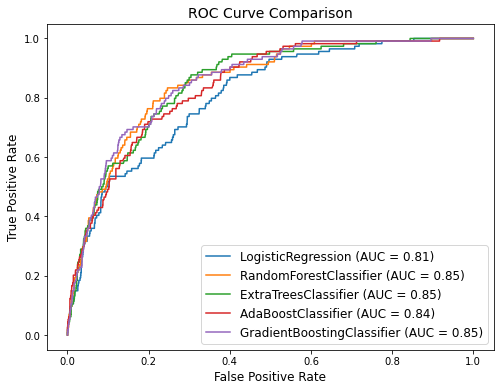

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
lr_disp = plot_roc_curve(best_model_lr, X_val_sc, y_val, ax=ax)
rf_disp = plot_roc_curve(best_model_rf, X_val_sc, y_val, ax=ax)
et_disp = plot_roc_curve(best_model_et, X_val_sc, y_val, ax=ax)
ada_disp = plot_roc_curve(best_model_ada, X_val_sc, y_val, ax=ax)
gb_disp = plot_roc_curve(best_model_gb, X_val_sc, y_val, ax=ax)
ax.set_title('ROC Curve Comparison', fontsize=14)
ax.legend(fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_xlabel('False Positive Rate', fontsize=12);

**Observations:**

From the above ROC we can see that Random Forest, Extra Trees and Gradient Boosting perform the slightly better than all the other models due to the the higher the AUC.

However, we still cannot determine which model that we will pick for our case as we are looking for the best performing model in terms of identifying false negative to prevent missing traps with potentially WNV presence which may cause lives. Even with a same model, we can increase the sensitivity of identifying positive case by adjusting the probability threshold accordingly. However, this is always with the cost of having higher false positive also (as there will be more datapoints that is considered to be in positive class). Therefore, the metric we are going to use is Sensitivity (TP/TP+FN) and Precision as the measure of false negative and false positive, accordingly. 

The approach we are going to take:
1. Start with threshold = 0 for predicting positive class. This means all data will be considered as positive class (similar to baseline model).
2. Slowly increase threshold for predicting positive class. This means there start to be more datapoints considered as **negative** class (as the probability given by the model is very low/ lower than the threshold).
3. Keep increasing threshold for predicting positive class. We will start seeing a **drop in sensitivity** due to false negative detection while we **increase precision** as false positive drops.
4. We will see which model that can **maintain the highest sensitivity with the highest increase in precision**. 

In [21]:
def plot_sensitivity_precision(model, label, ax):
    conf_matrix = []

    for threshold in np.linspace(0, 0.5, 25):
        y_preds = (model.predict_proba(X_val_sc)[:, 1] > threshold).astype('float')
        tn, fp, fn, tp = confusion_matrix(y_val, y_preds).ravel()
        sensitivity = tp/(tp + fn)
        if (tp + fp) == 0:
            precision = 0
        else:
            precision = tp/(tp + fp)
        conf_matrix.append([threshold, sensitivity, precision])
                   
    matrix = pd.DataFrame(conf_matrix, columns=['threshold', 'sensitivity', 'precision'])    

    ax.plot(matrix['precision'], matrix['sensitivity'], label=label)
    ax.set_xlabel('Precision')
    ax.set_ylabel('Sensitivity')
    
    return matrix

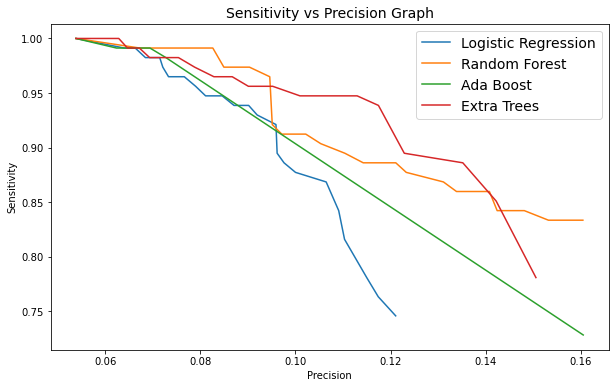

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

plot_sensitivity_precision(best_model_lr, 'Logistic Regression', ax)
plot_sensitivity_precision(best_model_rf, 'Random Forest', ax)
plot_sensitivity_precision(best_model_ada, 'Ada Boost', ax)
plot_sensitivity_precision(best_model_et, 'Extra Trees',ax)
ax.set_title('Sensitivity vs Precision Graph', fontsize=14)
ax.legend(fontsize=14);

**Observations:**

- From the graph above, Random Forest and Extra Trees seems to be performing the best as it can achieve higher precision and sensitivity compared to the other models.
- However, the training result of extra trees are unstable due to its random nature. Therefore, we will select Random Forest as it can reliably provide us a good results. 
- Based on the graph, we found that the threshold should be placed at 0.395 to obtain the highest sensitivity with reasonable precision. Therefore this value will be used to predict which trap to perform spraying subsequently.

### Feature Importance

Once the best model is chosen, we would like to understand the best feature to predict the presence of WNV. This feature importance is represented based on the value of coefficient.

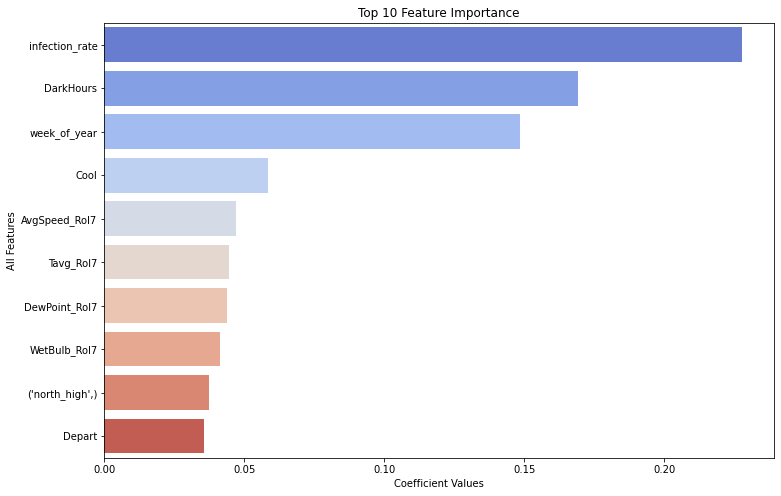

In [23]:
def top10_features(best_model, title):
    feature_imp = best_model_rf.feature_importances_

    feature_imp_df = pd.DataFrame(index=X.columns, data=feature_imp, 
                                  columns=['coefficient']).sort_values(by='coefficient', ascending=False).head(10)
    feature_imp_df.rename_axis('features', inplace=True)
    plt.figure(figsize=(12,8))
    sns.barplot(data=feature_imp_df,
                y=feature_imp_df.index, x='coefficient', orient='h', palette='coolwarm')
    plt.xlabel('Coefficient Values')
    plt.ylabel('All Features')
    plt.title('Top 10 Feature Importance')
    
top10_features(best_model_rf, 'Feature Importance');

**Observations:**
- As predicted, infection rate seems to be one of the most important feature as it contains the information form different mosquito species and the pattern of seasonality on weekly basis on a year. 
- DarkHours also comes out second, cementing further findings by multiple researchers that mosquito are more active at night, therefore having a longer night allows mosquito to have more active time per day. 
- The trap grouping features are very low in the list. Therefore, we can conclude that they are not as crucial as we originally think.

## Final Predictions

This final prediction is performed to produce probability of having WNV in the even years between 2008-2014. The ultimate purpose is to produce as accurate probability as possible to obtain high ROC-AUC score on [Kaggle challenge](https://www.kaggle.com/c/predict-west-nile-virus/submit). 

By right, we should perform another round of gridsearch based on 'ROC-AUC' as the 'scoring' metrics. However, after performing such a task, we found that the best model is still exactly converge to the model provided by gridsearch based on 'recall' as the scoring metrics. Therefore, for brevity, we will reuse the best model based on 'ROC-AUC' scoring. 

In [24]:
# Scale the data as we scale the input of best model initially
ss = StandardScaler()
X_test = test.drop(columns=['Id'])

train_sc = ss.fit_transform(X)
X_test_sc = ss.transform(X_test)

# Fit the model to the training set in 2007, 2009, 2011, 2013
best_model_rf.fit(train_sc, y)

# Predicting test data
predictions = best_model_rf.predict_proba(X_test_sc)[:,1]
pred_df = pd.DataFrame({'Id': test['Id'], 'WnvPresent': predictions})

# Exporting the data to a file to submit to kaggle
pred_df.to_csv('submission.csv', index=False)

Finally, based on this submission, we obtain Kaggle accuracy score of 0.74. 